# SOLUTION: Explore schema & access DQ

This notebook would explore `hacker-news` datasets following step-by-step of DQ checklist in [cheatsheets/data-quality-check.md](../cheatsheets/data-quality-check.md)

- [Check#0: Get-the-sense](#check0-get-the-sense)
- [Check#1: Timeliness/Historical](#check1-timeliness--historical)
- [Check#2: Completeness](#check2-completeness)
- [Check#3: Annotation](#check3-annotation)
- [Check#4: Consistency](#check4-consistency)
- [Check#5: Linkage](#check5-linkage)

In [27]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd 
import missingno as msno
import matplotlib.pyplot as plt

In [9]:
%ls ../credentials/ 

soy-storm-359817-3864bb8984b2.json


In [13]:
# Set up credentials 
project_id = 'soy-storm-359817'
credentials = service_account.Credentials.from_service_account_file('../credentials/soy-storm-359817-3864bb8984b2.json')

In [11]:
# test the connection
bq_client = bigquery.Client(
    project=project_id,
    credentials=credentials,
)

In [15]:
# parameters
project = 'bigquery-public-data'
dataset = 'hacker_news'

## Explore: Schema on BigQuery

`hacker_news`: This dataset contains all stories and comments from Hacker News from its launch in 2006.  Each story contains a story id, the author that made the post, when it was written, and the number of points the story received. 

In [3]:
from utils import bq_to_dataframe
from utils import bq_explore_schema

In [5]:
?bq_to_dataframe

Signature:
bq_to_dataframe(
    bq_client: google.cloud.bigquery.client.Client,
    sql_script: str,
) -> pandas.core.frame.DataFrame
Docstring:
Executes a SQL script and returns a pandas dataframe
Args:
    bq_client: BigQuery client
    sql_script: SQL script to be executed
Returns:
    pandas dataframe
File:      ~/Developer/analytics-training-samples/bigquery-notebooks/utils.py
Type:      function


In [6]:
?bq_explore_schema

Signature:
bq_explore_schema(
    bq_client: google.cloud.bigquery.client.Client,
    project: str,
    dataset: str,
) -> pandas.core.frame.DataFrame
Docstring:
Explores the schema of a BigQuery dataset
Args:
    bq_client: BigQuery client
    project: project id
    dataset: dataset name
Returns:
    pandas dataframe
File:      ~/Developer/analytics-training-samples/bigquery-notebooks/utils.py
Type:      function


### Relate Data & Front-end

Relate data to what actually happens in front-end is always a good idea! Check the website of Hackernews: https://news.ycombinator.com/. 

> How the columns and tables relate to specific components and features of HackerNews site?

### Check#0: Get-the-sense
This is how it looks like on Front-End: https://news.ycombinator.com/item?id=7266618 (You can query any `id` on the front-end).

1. `Story` would have these key information: `point`, `author`, `time` and `descendants` = total number of comments (direct and comment-under-comment)
2. `Comment` would have these key information: `author`, `time`, `parent`
3. `id` of stories would appear as `parent` of comments
4. `id` of comments could appear as `parent` of other replying comments

In [59]:
# This is a story
bq_to_dataframe(bq_client, 
    f'''
    SELECT  
        *
    FROM `bigquery-public-data.hacker_news.full_201510` 
    WHERE parent = 7266618
    OR id = 7266618
    ORDER BY time
    LIMIT 5
    '''
    )

,by,score,time,title,type,url,text,parent,deleted,dead,descendants,id,ranking
0,vassvdm,1129,1392847746,Facebook Buying WhatsApp for $16B in Cash and ...,story,http://techcrunch.com/2014/02/19/facebook-buyi...,,<NA>,<NA>,<NA>,802,7266618,<NA>
1,minimaxir,<NA>,1392847964,None,comment,None,Suddenly Snapchat at $3B doesn&#x27;t seem so ...,7266618,<NA>,<NA>,<NA>,7266651,<NA>
2,Karunamon,<NA>,1392847965,None,comment,None,Welp. There&#x27;s another app that I won&#x27...,7266618,<NA>,<NA>,<NA>,7266652,<NA>
3,higherpurpose,<NA>,1392847968,None,comment,None,Such a waste. Most Whatsapp users already use ...,7266618,<NA>,<NA>,<NA>,7266655,<NA>
4,None,<NA>,1392848005,None,comment,None,None,7266618,True,<NA>,<NA>,7266660,<NA>


In [68]:
# This is the comment as parent
bq_to_dataframe(bq_client, 
    f'''
    SELECT  
        *
    FROM `bigquery-public-data.hacker_news.full_201510` 
    WHERE id = 7266768
    OR parent = 7266768
    ORDER BY time
    LIMIT 5
    '''
    )

,by,score,time,title,type,url,text,parent,deleted,dead,descendants,id,ranking
0,None,<NA>,<NA>,None,comment_ranking,None,None,<NA>,<NA>,<NA>,<NA>,7266768,0
1,nwh,<NA>,1392848517,None,comment,None,"<p><pre><code> 400,000,000 active users [0]...",7266618,<NA>,<NA>,<NA>,7266768,<NA>
2,psbp,<NA>,1392848661,None,comment,None,Or facebook is trying to trivialize and destro...,7266768,<NA>,<NA>,<NA>,7266799,<NA>
3,mathattack,<NA>,1392848840,None,comment,None,I don&#x27;t think they&#x27;re buying it per ...,7266768,<NA>,<NA>,<NA>,7266834,<NA>
4,theboss,<NA>,1392848847,None,comment,None,Is it possible that this is also for user rete...,7266768,<NA>,<NA>,<NA>,7266836,<NA>


### Check schemas

We have written some handy functions in `utils.py` that help us to explore the schema

In [11]:
schema_data = bq_explore_schema(bq_client, project, dataset)
schema_data.head()

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position,collation_name,column_default
0,bigquery-public-data,hacker_news,full_201510,by,1,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL
1,bigquery-public-data,hacker_news,full_201510,score,2,YES,INT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL
2,bigquery-public-data,hacker_news,full_201510,time,3,YES,INT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL
3,bigquery-public-data,hacker_news,full_201510,title,4,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL
4,bigquery-public-data,hacker_news,full_201510,type,5,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL


In [12]:
# Loops through all tables in `haker_news` and list the column_name
for table in schema_data.table_name.unique():
    print(f'TABLE: {table}'.center(50, '-'))
    print(schema_data[schema_data.table_name==table].column_name.unique())

----------------TABLE: full_201510----------------
['by' 'score' 'time' 'title' 'type' 'url' 'text' 'parent' 'deleted' 'dead'
 'descendants' 'id' 'ranking']
-------------------TABLE: full--------------------
['title' 'url' 'text' 'dead' 'by' 'score' 'time' 'timestamp' 'type' 'id'
 'parent' 'descendants' 'ranking' 'deleted']
-----------------TABLE: comments------------------
['id' 'by' 'author' 'time' 'time_ts' 'text' 'parent' 'deleted' 'dead'
 'ranking']
------------------TABLE: stories------------------
['id' 'by' 'score' 'time' 'time_ts' 'title' 'url' 'text' 'deleted' 'dead'
 'descendants' 'author']


### Summary tables

In [13]:
df_summary = {}
for table in schema_data.table_name.unique():
    # Loop through all col and count
    derived_cols = '\n\t'.join({f'COUNT({col}) AS {col}_cnt,' for col in schema_data[schema_data.table_name==table].column_name if col != 'by'})
    print(f'TABLE: {table}')
    # Create the BQ query with the loop 
    summary_out = bq_to_dataframe(bq_client, 
    f'''
    SELECT
        COUNT(DISTINCT id) AS id_dist_cnt, 
        COUNT(id) AS row_cnt,
        TIMESTAMP_SECONDS(MIN(time)) AS min_time,
        TIMESTAMP_SECONDS(MAX(time)) AS max_time,
        {derived_cols}
    FROM `{project}.{dataset}.{table}`
    '''
    )
    # Append the result to the dictionary
    df_summary[table] = summary_out # Save the summary to dictionary for later 

        

TABLE: full_201510
TABLE: full
TABLE: comments
TABLE: stories


In [14]:
# Extract the summary of `full_201510`
df_summary['full_201510'].set_index('id_cnt').T

id_cnt,18778427
id_dist_cnt,10379010
row_cnt,18778427
min_time,2006-10-09 18:21:51+00:00
max_time,2015-10-13 08:44:34+00:00
dead_cnt,493886
url_cnt,1846185
ranking_cnt,8399638
time_cnt,10353068
descendants_cnt,1743034
title_cnt,1849180


In [15]:
# write the summary of BigQuery tables to a `hacker_news_summary.txt` file for later. 
with open('hacker_news_summary.txt', 'w') as f:
    for table in schema_data.table_name.unique():
        f.write(f'TABLE: {table}'.center(50, '-'))
        f.write('\n')
        f.write(str(df_summary[table].set_index('id_cnt').T))
        f.write('\n')

### Check#1: Timeliness / Historical

From the summary result stored in `hacker_news_summary.txt`:
- Table `full` includes the updated data from 2006 till now 2022
- Table `full_201510` (as the name) includes data till `2015-10-13`
- Table `full_201510` has `10,379,010` ids (ids seems duplicated)
- Table `comments` (same duration with `full_201510`) - has `8,399,417` (ids unique for rows)
- Table `stories` (same duration with `full_201510`) - has `1,959,809` (ids unique for rows)
- [CHECK] Consider the number of rows of `comments` and `stories`, we might have the educated guess that these two datasets are splitted from `full_201510`.

For our analysis, could scope down to focus on `2015` time-window (This is for the purpose of demo, we choose a smaller dataset to practice. In reality, we might prefer the `full` which are more updated)

### Check#2: Completeness

#### `full_201510`
- [GOOD] `type` highly available 100%
- [CHECK] `time_ts` supposed to highly available, but only available for 55%
- [CHECK] `title`, `parent`, `text`, `title`, `ranking` also not highly available

In [16]:
df_summ_full_201510 = df_summary['full_201510']
df_summ_full_201510.iloc[:, 4:].div(df_summ_full_201510['row_cnt'], axis=0)

,dead_cnt,id_cnt,url_cnt,ranking_cnt,time_cnt,descendants_cnt,title_cnt,parent_cnt,text_cnt,type_cnt,score_cnt,deleted_cnt
0,0.026301,1.0,0.098314,0.447303,0.551328,0.092821,0.098474,0.447904,0.512046,1.0,0.099024,0.017115


We also check the completness over time-period, counts of id increasing overtime (which is expected). 

For `2015-10`, the count is half of normal trends. This is because we only have the data till mid of 2015-10-13.

In [41]:
df_plt = bq_to_dataframe(bq_client, 
    f'''
    WITH tmp AS (
        SELECT
            id, 
            EXTRACT(YEAR FROM TIMESTAMP_SECONDS(time)) AS year,
            EXTRACT(MONTH FROM TIMESTAMP_SECONDS(time)) AS month,
        FROM `{project}.{dataset}.full_201510`
    )
        
    SELECT
        year,
        month,
        COUNT(DISTINCT id) AS id_uniq_cnt
    FROM tmp
    GROUP BY 1, 2
    ORDER BY 1, 2
    '''
    )

In [43]:
df_plt.tail()

,year,month,id_uniq_cnt
103,2015,6,171418
104,2015,7,175149
105,2015,8,164220
106,2015,9,158213
107,2015,10,70751


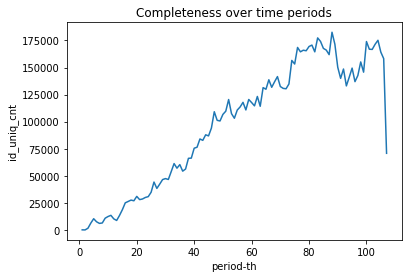

In [42]:
df_plt.dropna().id_uniq_cnt.plot()
plt.xlabel('period-th')
plt.ylabel('id_uniq_cnt')
plt.title('Completeness over time periods');

#### `stories`
- [GOOD] `time_ts`, `title`, `author`, `score`: highly available
- [CHECK] `text`: 30% missing (need to check)
- `dead`/`deleted`: missing not dead/delete
- `descendants`: missing mean no comment

In [17]:
df_summ_stories = df_summary['stories']
df_summ_stories.iloc[:, 4:].div(df_summ_stories['row_cnt'], axis=0)

,id_cnt,dead_cnt,url_cnt,time_ts_cnt,time_cnt,descendants_cnt,title_cnt,deleted_cnt,text_cnt,score_cnt,author_cnt
0,1.0,0.201216,0.938743,0.986876,0.986876,0.888657,0.939513,0.047361,0.727197,0.939515,0.939515


In [ ]:
bq_to_dataframe(bq_client, 
    f'''
    WITH tmp AS (
        SELECT
            id, 
            EXTRACT(YEAR FROM TIMESTAMP_SECONDS(time)) AS year,
            EXTRACT(MONTH FROM TIMESTAMP_SECONDS(time)) AS month,
        FROM `{project}.{dataset}.full_201510`
    )
        
    SELECT
        year,
        month,
        COUNT(DISTINCT id) AS id_uniq_cnt
    FROM tmp
    GROUP BY 1, 2
    ORDER BY 1, 2
    '''
    )

#### `comments`
- [GOOD] `time_ts`, `author`, `text`, `parent`: highly available
- [GOOD] `parent`: every comments should have a parent 
- [CHECK] `dead`: 80% missing (non-dead will receive Null value)
- [CHECK] `descendants`: 12% missing (no-replies will receive Null value)

In [18]:
df_summ_comments = df_summary['comments']
df_summ_comments.iloc[:, 4:].div(df_summ_comments['row_cnt'], axis=0)

,id_cnt,dead_cnt,ranking_cnt,time_cnt,time_ts_cnt,parent_cnt,text_cnt,deleted_cnt,author_cnt
0,1.0,0.011829,1.0,1.0,1.0,1.0,0.972886,0.027113,0.972887


## Explore: Deep-dive sample

Reading the information of `full_201510`, some columns will present the `linkage`:
- `id`: Unique ID (Is it unique for each row? Each row = 1 post?)
- `parent`: ID of the parent
- `type`: Type of details (comment, comment_ranking, poll, story, job, pollopt)

In [71]:
full_201510 = bq_to_dataframe(bq_client, 
    f'''
    SELECT
        id, 
        `by`,
        type,
        TIMESTAMP_SECONDS(time) AS time_ts,
        title, 
        parent,
        descendants,
        score,
        ranking,
        dead,
        deleted
    FROM `{project}.{dataset}.full_201510`
    TABLESAMPLE SYSTEM (5 PERCENT)
    '''
    )

### Check#3: Annotation

Check if the `type` consistent with the annotation and description. 

We see that each row in the `full` table belongs to different types (including: `comment` and `story`)

In [72]:
full_201510.type.value_counts()

comment            254729
comment_ranking    254522
story               59414
pollopt               356
job                   190
poll                   49
Name: type, dtype: int64

Deep-dive into the completeness of each `type`, we answer some questions about data quality in **Conclusion #2**: 

- [OK] `time_ts` supposed to highly available, but only available for 55% ==> No time for `comment_ranking`. Highly available for other types
- [OK] Different `types` have the highly-available critical variables go with it
    - `stories`: time, author, title, score, descendants
    - `comments`: time, author, parent 

Help to understand better the data linkage:

1. `story`: Have no `parent`, likely have `descendants` (highly available `time` and `author`)
2. `comment`: Always have `parent`, no `descendants` (highly available `time` and `author`)
3. Missing of `time` likely comes from `comment_ranking` (only have the `ranking` information, and id)

We will focus on `comment`, `story`, and `comment_ranking` as the rest seems insignificant.

In [73]:
full_201510.groupby('type').count()

,id,by,time_ts,title,parent,descendants,score,ranking,dead,deleted
type,,,,,,,,,,
comment,254729,247855,254729,0,254729,0,1,0,3009,6874
comment_ranking,254522,0,0,0,0,0,0,254522,0,0
job,190,177,190,177,0,0,177,0,2,13
poll,49,43,49,43,0,41,43,0,4,6
pollopt,356,351,356,17,353,0,351,0,0,5
story,59414,55839,58612,55839,0,52796,55839,0,11973,2773


In [74]:
full_201510[full_201510.type=='story'].count() / full_201510[full_201510.type=='story'].id.count()

id             1.000000
by             0.939829
type           1.000000
time_ts        0.986501
title          0.939829
parent         0.000000
descendants    0.888612
score          0.939829
ranking        0.000000
dead           0.201518
deleted        0.046673
dtype: float64

In [75]:
full_201510[full_201510.type=='comment'].count() / full_201510[full_201510.type=='comment'].id.count()

id             1.000000
by             0.973014
type           1.000000
time_ts        1.000000
title          0.000000
parent         1.000000
descendants    0.000000
score          0.000004
ranking        0.000000
dead           0.011813
deleted        0.026986
dtype: float64

Some python module would help to visualize the missing status. Here we use `missingno`.
Comparing the the missing matrix of the whole datatset `full_201510`. Dividing by `type` gives us much clearer pattern of missing.

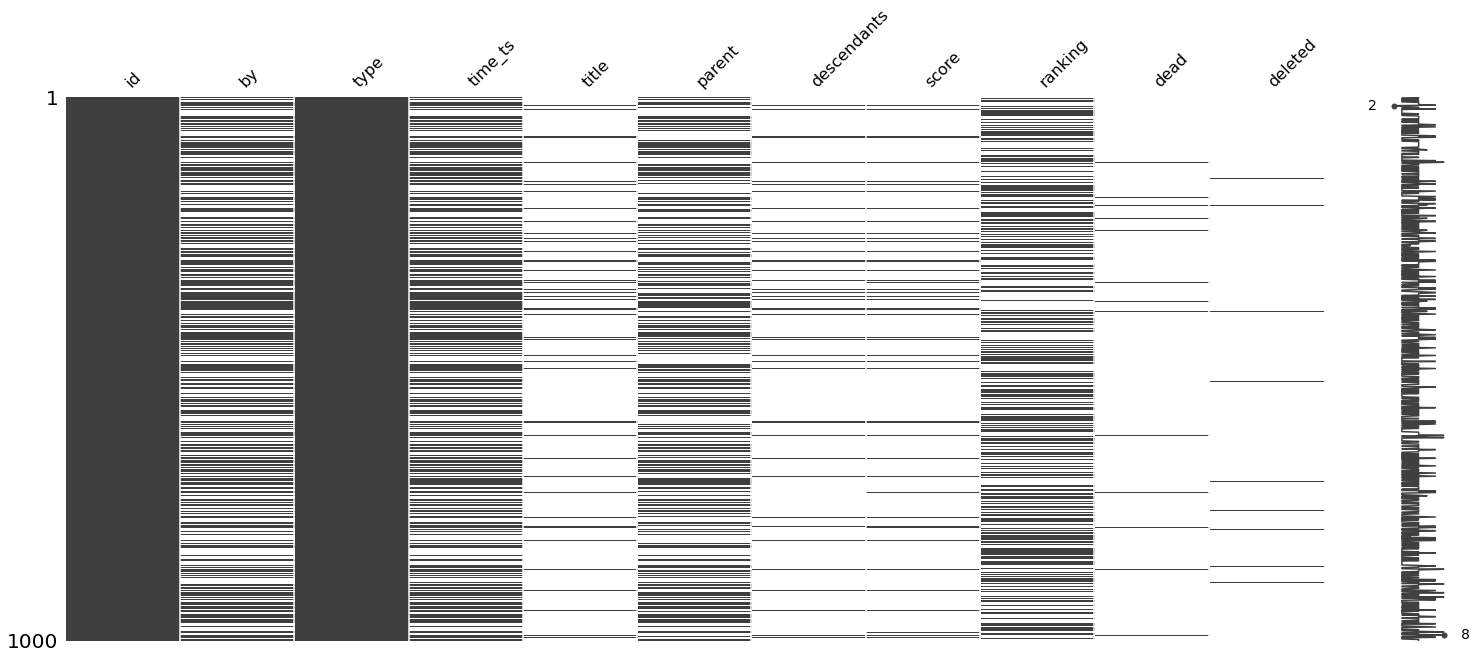

In [76]:
msno.matrix(full_201510.sample(1000));

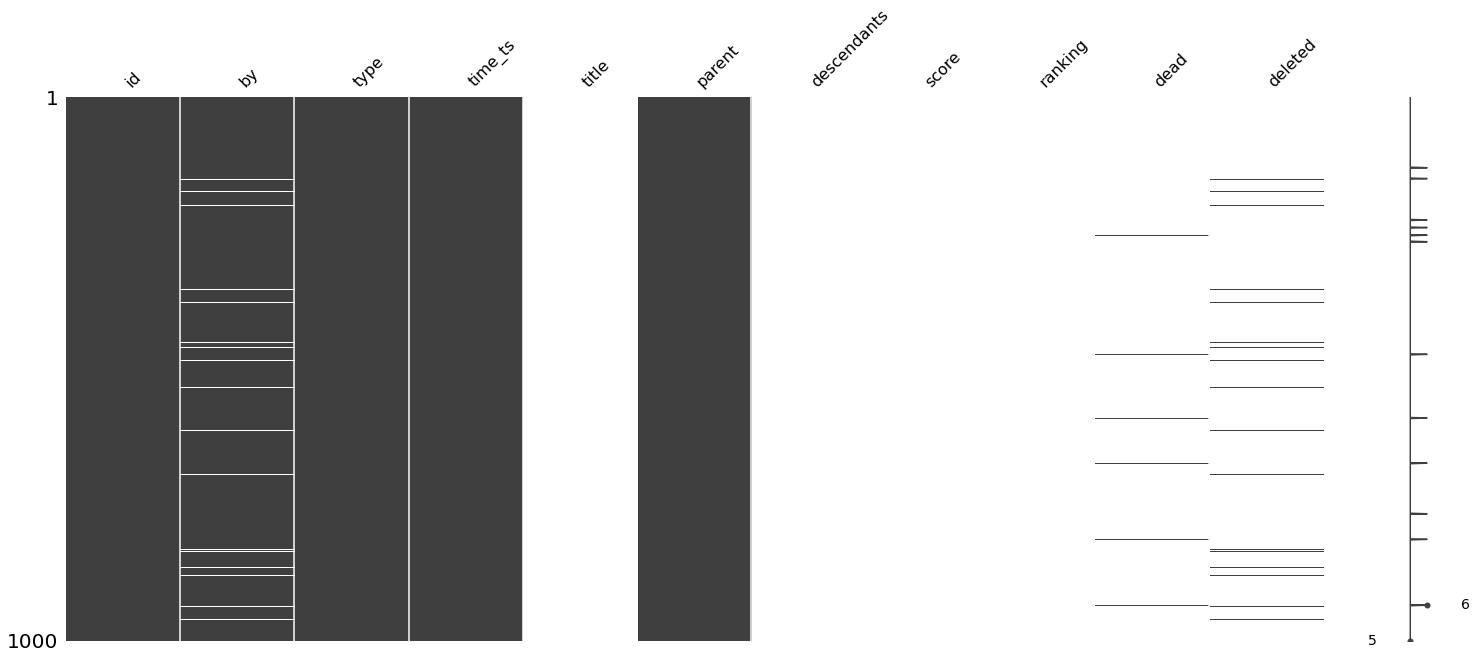

In [77]:
msno.matrix(full_201510[full_201510.type=='comment'].sample(1000));

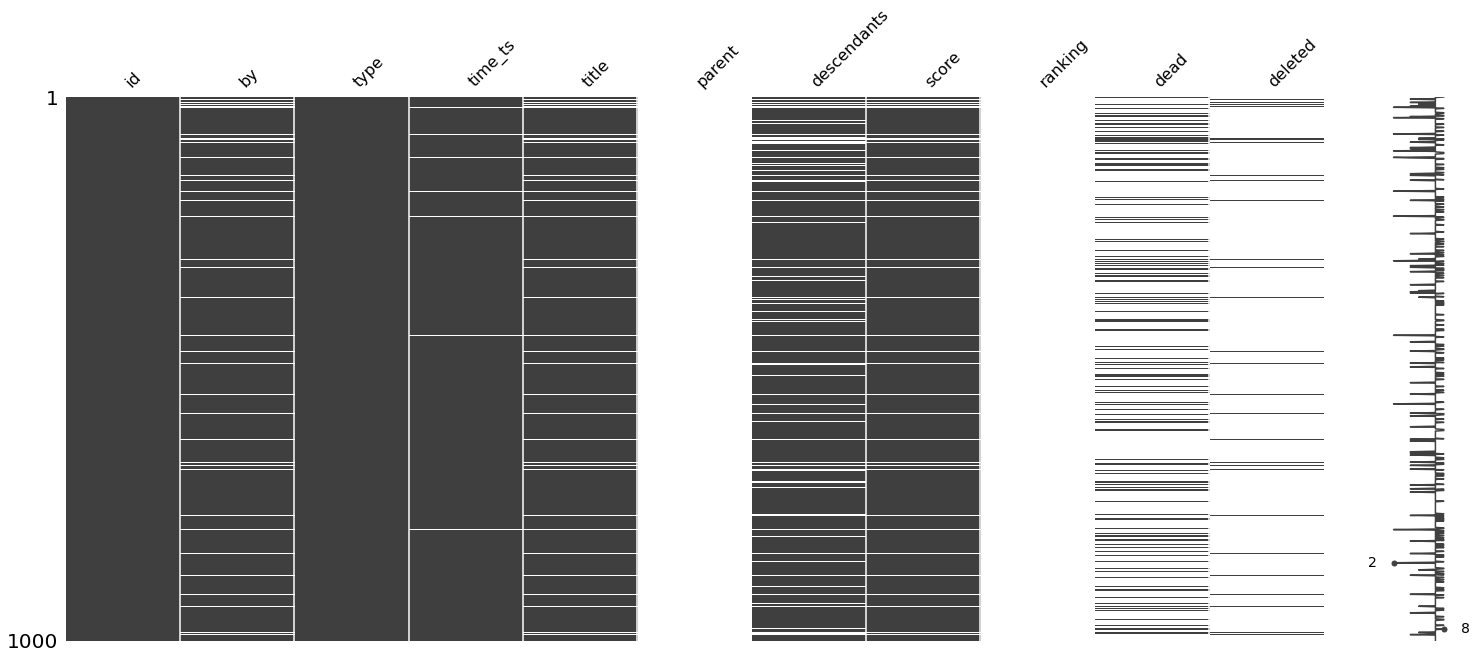

In [78]:
msno.matrix(full_201510[full_201510.type=='story'].sample(1000));

## Check#4: Consistency

In [79]:
# Check the datatype (can compare with data dictionary)
full_201510.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569260 entries, 0 to 569259
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   id           569260 non-null  Int64              
 1   by           304265 non-null  object             
 2   type         569260 non-null  object             
 3   time_ts      313936 non-null  datetime64[ns, UTC]
 4   title        56076 non-null   object             
 5   parent       255082 non-null  Int64              
 6   descendants  52837 non-null   Int64              
 7   score        56411 non-null   Int64              
 8   ranking      254522 non-null  Int64              
 9   dead         14988 non-null   boolean            
 10  deleted      9671 non-null    boolean            
dtypes: Int64(5), boolean(2), datetime64[ns, UTC](1), object(3)
memory usage: 44.0+ MB


- `id` and `parent` have similar range => These two are likely same id-format and could be mappable
- `descendants`: the range is consistent with description of "Number of story or poll descendants" (some weird value: -1) 
- `score` and `ranking`: from 1-3 (outliers)

In [80]:
# Check the range
full_201510.describe()

,id,parent,descendants,score,ranking,dead,deleted
count,5.692600e+05,2.550820e+05,52837.000000,56411.000000,254522.000000,14988,9671
unique,NaN,NaN,NaN,NaN,NaN,1,1
top,NaN,NaN,NaN,NaN,NaN,True,True
freq,NaN,NaN,NaN,NaN,NaN,14988,9671
mean,5.215180e+06,5.242508e+06,4.651551,10.933577,3.998464,NaN,NaN
std,2.995996e+06,2.997924e+06,20.966521,45.072216,19.309584,NaN,NaN
min,6.300000e+01,1.200000e+01,-1.000000,0.000000,0.000000,NaN,NaN
25%,2.604885e+06,2.611453e+06,0.000000,1.000000,0.000000,NaN,NaN
50%,5.240930e+06,5.302654e+06,0.000000,2.000000,1.000000,NaN,NaN
75%,7.803104e+06,7.824519e+06,1.000000,4.000000,3.000000,NaN,NaN


## Check#5: Linkage

Based on the previous analysis, we can come with potential linkage of the data:

1. How to link `comment_ranking` to `comment`? ==> `id`
2. How to link `comment` to `story`?
    - `story` has `id` in `parent` of `comment`

Notice that as we use the sample, not all ids are mappable. We check if the id is potential to use for the linkage, with the `any()`

In [ ]:
# Cross-check if any id mappable (overlapped)?
for type_1 in ['comment_ranking', 'job', 'poll', 'pollopt', 'comment']:
    for type_2 in ['comment_ranking', 'job', 'poll', 'pollopt', 'comment']:
        check = any(full_201510[full_201510.type==type_1].id.isin(full_201510[full_201510.type==type_2].id))
        print(f'Check OVERLAP pair: {type_1} x {type_2} ==> {check}')
    print('-'*20)

Check OVERLAP pair: comment_ranking x comment_ranking ==> True
Check OVERLAP pair: comment_ranking x job ==> False
Check OVERLAP pair: comment_ranking x poll ==> False
Check OVERLAP pair: comment_ranking x pollopt ==> False
Check OVERLAP pair: comment_ranking x comment ==> True
--------------------
Check OVERLAP pair: job x comment_ranking ==> False
Check OVERLAP pair: job x job ==> True
Check OVERLAP pair: job x poll ==> False
Check OVERLAP pair: job x pollopt ==> False
Check OVERLAP pair: job x comment ==> False
--------------------
Check OVERLAP pair: poll x comment_ranking ==> False
Check OVERLAP pair: poll x job ==> False
Check OVERLAP pair: poll x poll ==> True
Check OVERLAP pair: poll x pollopt ==> False
Check OVERLAP pair: poll x comment ==> False
--------------------
Check OVERLAP pair: pollopt x comment_ranking ==> False
Check OVERLAP pair: pollopt x job ==> False
Check OVERLAP pair: pollopt x poll ==> False
Check OVERLAP pair: pollopt x pollopt ==> True
Check OVERLAP pair: p

In [ ]:
# `story` has `id` in `parent` of `comment`
any(full_201510[full_201510.type=='story'].id.isin(full_201510[full_201510.type=='comment'].parent))

True

In [69]:
# `comment` has `id` in `parent` of `comment`
any(full_201510[full_201510.type=='comment'].id.isin(full_201510[full_201510.type=='comment'].parent))

True

Lastly, check if the `comments` and `stories` are splitted and processed from `full_201510` table.

> [CHECK] Consider the number of rows of `comments` and `stories`, we might have the educated guess that these two datasets are splitted from `full_201510`.

In [ ]:
bq_to_dataframe(bq_client, 
    f'''
    SELECT
        COUNT(DISTINCT s.id) / COUNT(DISTINCT f.id) AS story_id_coverage
    FROM `{project}.{dataset}.full_201510` AS f
    LEFT OUTER JOIN `{project}.{dataset}.stories` AS s
    ON s.id = f.id
    WHERE f.type='story'
    '''
    )

,story_id_coverage
0,1.0


In [219]:
bq_to_dataframe(bq_client, 
    f'''
    SELECT
        COUNT(DISTINCT c.id) / COUNT(DISTINCT f.id) AS comment_id_coverage
    FROM `{project}.{dataset}.full_201510` AS f
    LEFT OUTER JOIN `{project}.{dataset}.comments` AS c
    ON c.id = f.id
    WHERE f.type='comment'
    '''
    )

,comment_id_coverage
0,0.99994


Now, we are ready to build the DB diagram, and select the data for our next steps.
![image](img/hackernews-diagram.png)

### Other checks

In [81]:
bq_to_dataframe(bq_client, 
    f'''
    SELECT
        *
    FROM `{project}.{dataset}.stories`
    WHERE `by` != author
    '''
    )

,id,by,score,time,time_ts,title,url,text,deleted,dead,descendants,author
